# Lection 6


<h2>Транзакции.</h2>

* Требования к транзакции
* Журнал транзакций
* Обеспечения изолированности и атомарности, MVCC
* Уровни изоляции транзакций
* Проблемы современного доступа к данным

В PostgreSQL каждый оператор рассматривается как отдельная транзакция. Это означает, что если вы выполняете операцию SELECT, INSERT или другую команду без начала транзакции (оператор BEGIN), то эта команда автоматически запустится  внутри собственной транзакции. Для отмены действия используется оператор ROLLBACK.

Точки сохранения — это инструмент для управления транзакциями в базе данных. Оператор SAVEPOINT позволяет создавать своего рода «закладки» внутри текущей транзакции и  фиксировать состояние базы данных на момент создания точек. Это дает возможность разделить сложные операции на логические этапы. Если необходимо откатить часть изменений в рамках транзакции, то можно воспользоваться точкой сохранения вместо полного отката.

SAVEPOINT работает в паре с оператором ROLLBACK TO. При создании точки сохранения даем ей название, и , если необходимо откатить изменения, выбираем точку до которой хотим вернуться. Этот механизм предоставляет контроль над откатом изменений в базе данных.

<h2>Требования к транзакции</h2>

Требования ACID  — основа обеспечения надежности и целостности данных при одновременном выполнении транзакций.

ACID — это акроним, который включает в себя четыре требования:

1) Атомарность. Транзакция — атомарная единица работы. Если одна ее часть не может быть выполнена (например, из-за сбоя), то все изменения, которые сделаны другими частями, откатываются. Нет промежуточных состояний.

2) Согласованность. Все ограничения целостности базы данных должны быть соблюдены в конце каждой транзакции. Если транзакция не удовлетворяет ограничениям целостности, она откатывается. База данных остается в прежнем состоянии.

3) Изолированность. Изменения, внесенные внутри одной транзакции, не видны другим до ее завершения. Это предотвращает конфликты между транзакциями, когда они пытаются получить доступ к одним и тем же данным одновременно.

4) Долговечность. Данные, которые записаны в базу данных при успешной транзакции, должны быть устойчивыми к сбоям. Данные должны оставаться неизменными даже после перезапуска системы.



<h2>Журнал транзакций</h2>

**Журнал транзакций** — это структура данных, используемая в базах данных и других системах для фиксации всех изменений (операций), происходящих в системе. Он обеспечивает надежность, целостность данных и возможность восстановления в случае сбоев.  

Журнал транзакций записывает все операции, такие как вставка, обновление и удаление данных, в хронологическом порядке. Каждая транзакция фиксируется в журнале до её завершения: если транзакция выполняется успешно, данные фиксируются (commit), а в случае ошибки — откатываются (rollback). Журнал содержит не только изменения данных, но и метаданные, включая идентификаторы транзакций и временные метки.  

Основное назначение журнала транзакций — обеспечение атомарности, согласованности, изоляции и долговечности данных (ACID). Это позволяет системе восстанавливать данные после сбоев, поддерживать целостность и откатывать изменения при необходимости. Журнал транзакций также используется для синхронизации данных в распределенных системах и репликации между серверами.  

Эта технология широко применяется в современных системах управления базами данных (например, PostgreSQL, Oracle, MySQL), в файловых системах (таких как NTFS и ext4), а также в распределенных системах и блокчейне. Журнал транзакций обеспечивает надежность, отказоустойчивость и высокую целостность данных в самых разнообразных сценариях использования.

<h2>Обеспечения изолированности и атомарности, MVCC</h2>

Изоляция решает задачу доступа к данным в конкурентной среде, фактически предоставляя защиту от race condition'ов. В идеале, изоляция означает сериализацию, то есть свойство, обеспечивающее то, что результат выполнения транзакций параллельно такой же, как если бы они выполнялись последовательно. Основная проблема данного свойства заключается в том, что оно очень тяжело обеспечивается технически и как следствие сильно бьет по производительности системы. Именно поэтому изоляцию часто ослабляют, принимая риски возникновения некоторых аномалий, о которых речь пойдет ниже. Возможность возникновения тех или иных аномалий как раз таки и характеризует уровень изоляции транзакций.

Наиболее известными аномалиями являются: dirty read, non-repeatable read, phantom read

<h3>Dirty write</h3>

Суть аномалии заключается в том, что транзакции могут перезаписывать незакоммиченные данные.

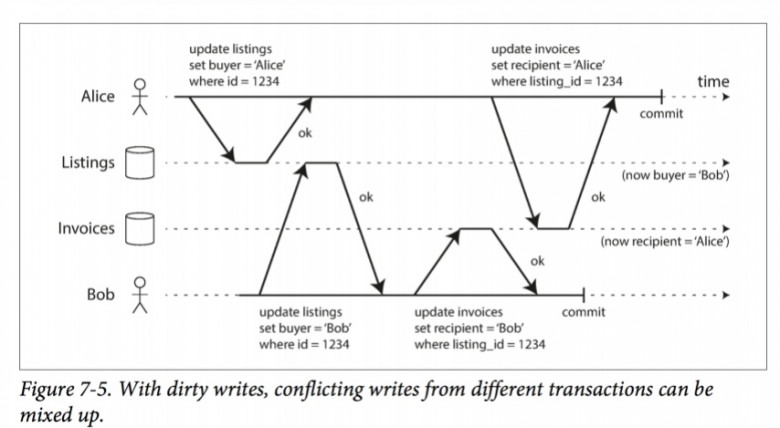

Данная аномалия опасна не только тем, что данные могут конфликтовать после коммита обеих транзакций (как на картинке), но и тем, что нарушается атомарность: потому что мы разрешим перезаписывать незакоммиченные данные, то непонятно, как откатить одну транзакцию, не задев при этом другую.

<h3>Dirty read</h3>

Dirty read означает прочтение незакоммиченных данных.

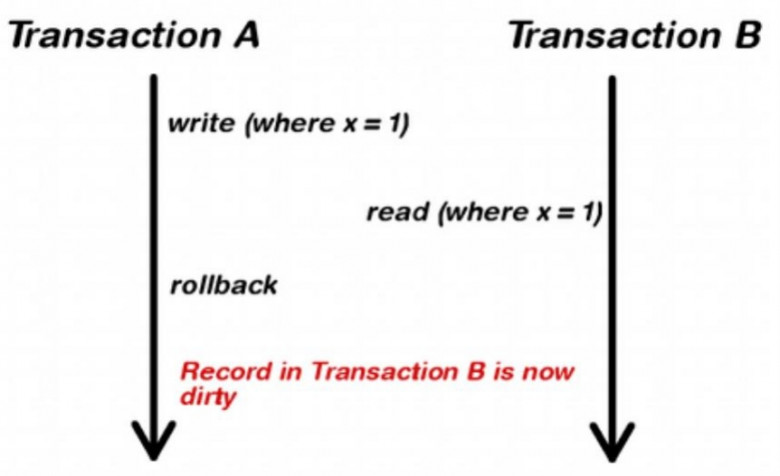

Проблемы возникают, когда на основе выборки необходимо осуществить какие-то действия или принять решения.

<h3>Non-repeatable read</h3>

Non-repeatable read заключается в том, что во время выполнения нашей транзакции 2 последовательных чтения одной и той же записи приведет к получению различных результатов, потому что другая транзакция вмешалась между этими двумя чтениями, поменяла наши данные и была закоммичена.

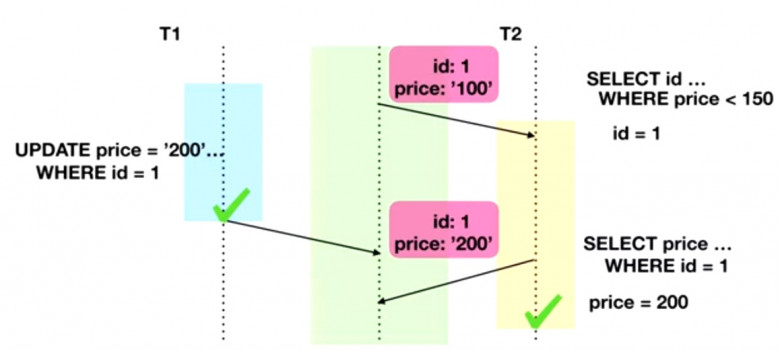

Phantom read

Фантомным называется чтение данных, которые были добавлены другой транзакцией.

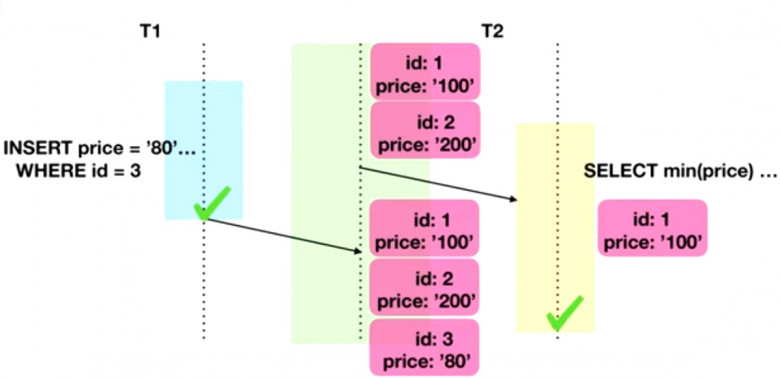

В качестве примера можно наблюдать неправильную выборку самого дешевого товара при возникновении данной аномалии.

Реализация механизма хранения транзакций зависит от базы данных.

PostgreSQL

Каждая транзакция характеризуется некоторым id-шником. Id-шники транзакций монотонно растут. У любой строчки есть 2 атрибута, которые представляют метаинформацию для обеспечения механизма: updated_by_id — id-шник транзакции, которая последней осуществила обновление этой записи и deleted_by_id — id-шник транзакции, которая удалила данную запись. Когда приходит новая транзакция, база данных определяет id-ники выполняемых на данный момент транзакций, изменения, внесенные этими транзакциями, будут в рамках пришедшей транзакции проигнорированы. Получается, что пришедшая транзакция работает как бы со своей версией данных. Старые версии данных хранятся там же, где и актуальные. Если приходит Update, то добавляется еще одна строка и эта запись становится активной. Также понятно, что для корректной работы этой схемы необходим «сборщик мусора»: если у какой-то записи стоит deleted_by_id = 100, а минимальный id-шник среди выполняемых в данный момент транзакций это 150, то такую запись необходимо удалить.

<h2>Уровни изоляции транзакций</h2>

<h3> Уровень изоляции Read Committed </h3>

По умолчанию в PostgreSQL уровень изоляции Read Committed. Такой уровень изоляции всегда позволяет видеть изменения внесённые успешно завершёнными транзакциями в оставшихся параллельно открытых транзакциях. В транзакции, работающей на этом уровне, запрос SELECT (без предложения FOR UPDATE/SHARE) видит только те данные, которые были зафиксированы до начала запроса; он никогда не увидит незафиксированных данных или изменений, внесённых в процессе выполнения запроса параллельными транзакциями. По сути запрос SELECT видит снимок базы данных в момент начала выполнения запроса. Однако SELECT видит результаты изменений, внесённых ранее в этой же транзакции, даже если они ещё не зафиксированы. Также заметьте, что два последовательных оператора SELECT могут видеть разные данные даже в рамках одной транзакции, если какие-то другие транзакции зафиксируют изменения после выполнения первого SELECT.

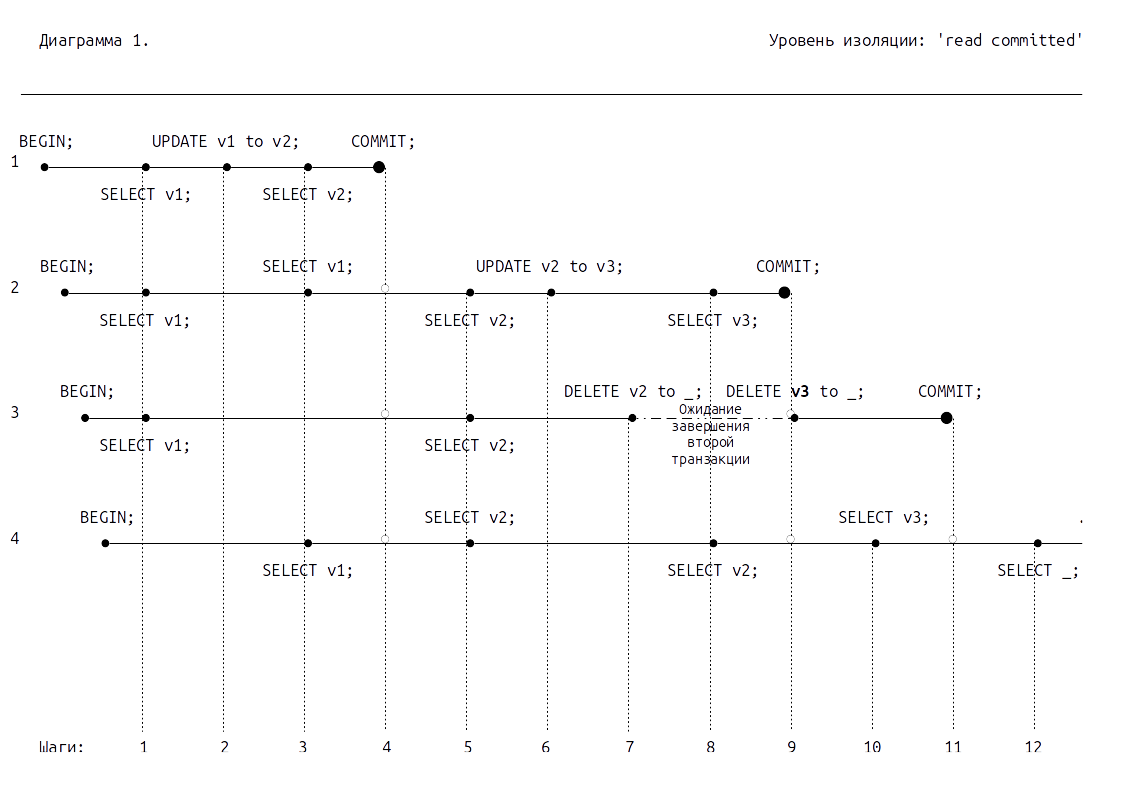

*Шаг 1.* В начальный момент времени до каких-либо изменений данных всем транзакциям доступна изначальная версия данных (v1);

*Шаг 2.* В ходе работы Первой транзакции данные без каких либо блокировок успешно обновляются до «второй версии» (v2);

*Шаг 3.* Изменения сделанные в Первой транзакции будут видны только ей самой (SELECT возвращает v2), и не будут доступны остальным транзакциям (SELECT запрос во Второй и Четвёртой транзакциях возвращает v1);

*Шаг 4.* Закрытие Первой транзакции. Все изменения сделанные в ходе её работы успешно фиксируются;

*Шаг 5.* После закрытия Первой транзакции (предыдущий шаг), изменения сделанные в ходе её выполнения над данными (обновление с v1 до v2) были распространены на остальные транзакции, SELECT запрос в оставшихся 3 открытых транзакциях возвращает v2 («Неповторяемое чтение», отличие уровня изоляции Read Committed от Serializable);

*Шаг 6.* Запрос на обновление данных во Второй транзакции до «третьей версии» успешно выполняется, но запросы на обновление данных блокируют изменяемые строки на дальнейшее их изменение, до завершения Второй транзакции;

*Шаг 7.* Из-за блокировки наложенной на данные в предыдущем шаге, Третья транзакция переходит в режим ожидания с запросом на удаление данных. Ожидание Третьей транзакции будет происходить до закрытия Второй транзакции;

*Шаг 8.* Несмотря на то, что Третья транзакция ожидает закрытия Второй, как Вторая так и Четвёртая транзакции без каких либо проблем продолжают свою работу, возвращая данные согласно своим версиям. Вторая возвращает v3, Четвёртая возвращает v2;

*Шаг 9.* Закрытие Второй транзакции приводит к разблокированию данных для изменения. Уровень изоляции Read Committed позволяет продолжить работу Третьей транзакции без вызова ошибки. Получив доступ на изменение новой версии данных (v3) Третья транзакция УСПЕШНО тут же их «удаляет» (отличие Read Committed от Serializable);

*Шаг 10.* До закрытия Третьей транзакции, данные будут удалёнными только внутри Третьей транзакции. Четвёртой транзакции до закрытия Третьей данные доступны (SELECT запрос в Четвёртой транзакции возвращает v3);

*Шаг 11.* Закрытие Третьей транзакции. Все изменения сделанные в ходе её работы успешно фиксируются;

*Шаг 12.* Запрос на получение данных в Четвёртой транзакции ничего не возвращает («Фантомное чтение», SELECT запрос возвращает 0 записей).

<h3> Уровень изоляции Serializable </h3>

Изоляция уровня Serializable обеспечивает беспрепятственный доступ к базе данных транзакциям с SELECT запросами. Но для транзакций с запросами UPDATE и DELETE, уровень изоляции Serializable не допускает модификации одной и той же строки в рамках разных транзакций. При изоляции такого уровня все транзакции обрабатываются так, как будто они все запущены последовательно (одна за другой). Если две одновременные транзакции попытаются обновить одну и туже строку, то это будет не возможно. В таком случае PostgreSQL принудит транзакцию, вторую, да и все последующие, что пытались изменить строку к отмене (откату — ROLLBACK).

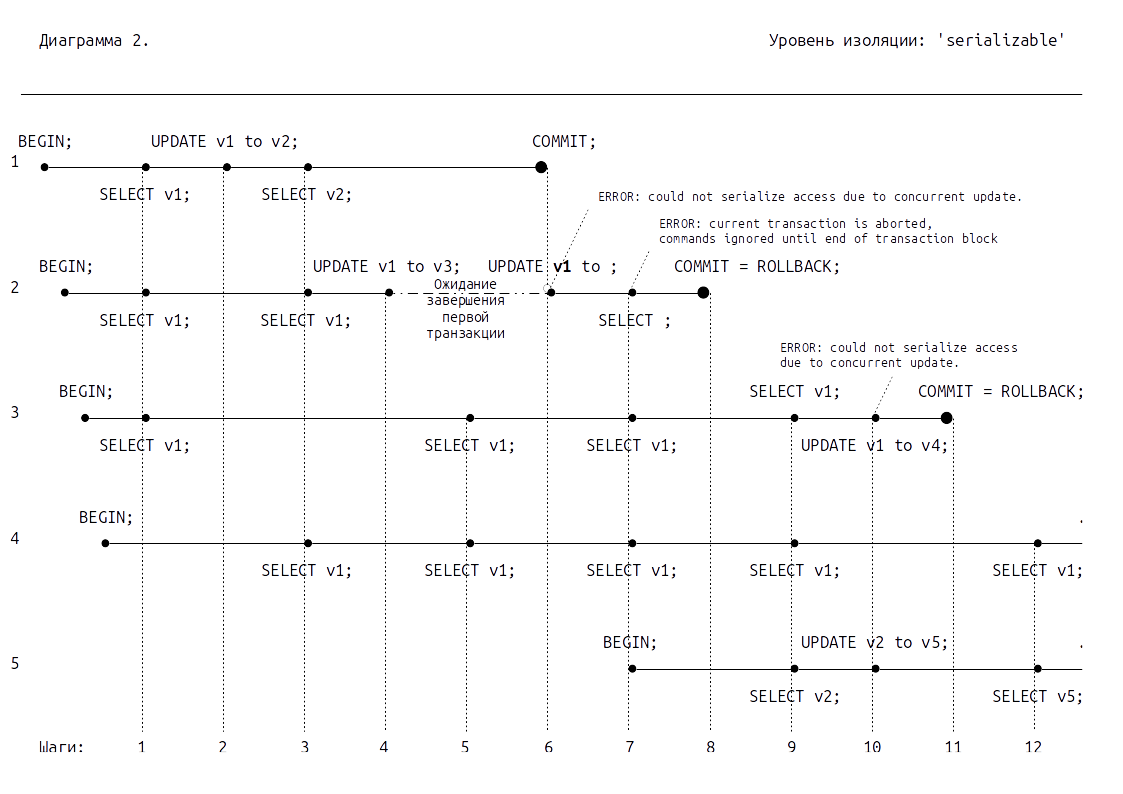                                                                                                                   *Шаг 1.* Всем транзакциям доступна изначальная версия данных (v1);

*Шаг 2.* В ходе работы Первой транзакции данные без каких либо блокировок успешно обновляются до «второй версии» (v2);

*Шаг 3.* Изменения сделанные в Первой транзакции будут видны только ей самой (SELECT возвращает v2), и не будут доступны остальным транзакциям (SELECT запрос во Второй и Четвёртой транзакциях возвращает v1);

*Шаг 4.* Запрос на обновление данных в первой транзакции (шаг 2), блокирует обновляемые строки, и переводит в режим ожидания Вторую транзакцию с запросом на обновление данных. Блокировка транзакций на обновляемые данных будет происходить до закрытия Первой транзакции;

*Шаг 5.* Несмотря на то, что Вторая транзакция ожидает закрытия Первой, как Третья так и Четвёртая транзакции без каких либо проблем продолжают свою работу, возвращая данные согласно своим версиям;

*Шаг 6.* Завершение Первой транзакции снимает блокировку с обновляемых данных, но в рамках уровня изоляции Serializable повторное обновление данных в параллельных транзакциях запрещено, и поэтому в ходе выполнения Второй транзакции возникает ошибка (отличие Serializable от Read Committed);

*Шаг 7.* Запрос SELECT во Второй транзакции становится невозможным, так как ошибка возникшая на предыдущем шаге отменяет («блокирует») транзакцию. Запрос SELECT в Третьей и Четвертой транзакциях возвращают первоначальную версию данных (v1). Несмотря на то, что Первая транзакция была завершена успешно, изменения не стали видны остальным открытым транзакциям (отличие Serializable от Read Committed). Открытие Пятой транзакции в левом верхнем окне;

*Шаг 8.* Закрытие Второй транзакции. Все изменения сделанные данной транзакцией будут отменены, из-за возникшей ошибки в ходе её работы;

*Шаг 9.* Запрос SELECT в Пятой транзакции возвращает новую версию данных (v2). Запрос SELECT в Третьей и Четвёртой транзакциях возвращают первоначальную версию данных (v1);

*Шаг 10.* Уровень изоляции Serializable всё также не даёт обновлять данные, запрос UPDATE в Третьей транзакции завершается не удачно, с вытекающими последствиями для хода всей транзакции (несмотря на то, что Первая транзакция уже удачно завершилась, и все внесённые ей изменения сохранены в базе данных). А вот запрос UPDATE в Пятой транзакции завершается успешно, так как она открыта после завершения Первой транзакции, и работает с новой версией данных;

*Шаг 11.* Закрытие Третьей транзакции. Все изменения сделанные данной транзакцией будут отменены, из-за возникшей ошибки в ходе её работы;

*Шаг 12.* Транзакция Четыре всё также показывает, что у транзакций с SELECT запросами никаких нет проблем, а Пятая транзакция получает уже обновлённые же собой данные (v5).    

<h2>Проблемы современного доступа к данным</h2>

<h3> Основные угрозы, с которыми сталкиваются базы данных, включают в себя: </h3>

* SQL-инъекции — это тип атак, при котором злоумышленник использует ошибки в веб-сайте или приложении, чтобы получить доступ к базе данных. Как правило, это происходит путем внедрения вредоносного кода на языке SQL в формы, полей ввода или через иные сервисы. Злоумышленник может вводить команды SQL, вместо того, что вводить стандартные параметры. Это позволяет ему получить доступ к важной информации или изменять содержимое базы данных. Пример: злоумышленник может добавить команду DELETE, чтобы удалить данные из базы.

* Взлом паролей — это атака, при которой злоумышленник пытается угадать пароль или использовать слабые пароли для получения доступ к базе данных. Взлом паролей может быть автоматизирован, используя программы для перебора паролей(брутфорс), что позволяет злоумышленнику быстро найти правильный пароль и получить доступ к ценной информации.

* Несанкционированный доступ к данным — это когда злоумышленник получает доступ к базе данных без разрешения владельца или администратора базы данных. Это может происходить путем использования слабых паролей или уязвимостей в системе безопасности. В результате злоумышленник может получить доступ к конфиденциальной информации и использовать ее в своих корыстных целях.

* В истории есть масса проблем, связанных с безопасностью баз данных. Одной из самой известной является атака на базу данных Equifax в 2017 году, когда злоумышленники украли личную информацию более чем 143 миллионов человек. Эта атака произошла из-за невообразимо слабых паролей и уязвимостей в самой системе безопасности.